# Real Estate Investments Attica

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import matplotlib.patches as patches
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff
from functools import reduce

In [2]:
#'Spitogatos_Athens_Center_For_Sale.xlsx'
# 'Spitogatos_Athens_Center_Rent.xlsx'

## Data Cleaning

In [3]:
#def real_estate_final_format(sales_excel, rent_excel):
    
#Sales Data Manipulations

df_sales_0 = pd.read_csv('Spitogatos_Athens_Center_For_Sale.csv').drop_duplicates(subset=['House ID']).reset_index().drop(columns = ["Unnamed: 0"]) 
df_sales_1 = df_sales_0[~(df_sales_0['Price'] > 3000000)]
df_sales_location = df_sales_1[["Price", "Square meters house" , "Number of Bedrooms" , "Location" , "price_per_sqrmeter"]].groupby(['Location']).mean().reset_index()
df_sales_location['Count'] =  df_sales_1[['Price', 'Location']].groupby(['Location']).count().reset_index()['Price']
df_sales_2 = df_sales_location[~(df_sales_location['Count'] <= 100)].sort_values(by='Count').reset_index().drop(columns = ['index']).rename(columns={"Price": "Average Price by Location",
                                                        "Square meters house": "Average Square meters by Location",
                                                        "Number of Bedrooms":"Average Number of Bedrooms by Location"}).drop(columns = ['price_per_sqrmeter','Count'])
final_dataframe_location = pd.merge(df_sales_1,df_sales_2, on="Location")
drop_many_bedrooms = final_dataframe_location[~(final_dataframe_location['Number of Bedrooms'] >= 5 )].reset_index().drop(columns = ['index'])
drop_final = drop_many_bedrooms[~(drop_many_bedrooms['Number of Bedrooms'] < 1 )].reset_index().drop(columns = ['index'])
df_sales_3 = drop_final.drop(columns = ['level_0',"Average Price by Location", "Average Square meters by Location" ,"Average Number of Bedrooms by Location"])
grouped_bedrooms = df_sales_3.groupby(['Location','Number of Bedrooms']).mean().reset_index().drop(columns = ['House ID']).rename(columns={"Price": "Average Price by Location/# Bedrooms",
                                                        "Square meters house": "Average Square meters by Location/# Bedrooms" , 
                                                        "price_per_sqrmeter": "Average price_per_sqrmeter by Location/# Bedrooms"}).round(2)
    
#Rent Data Manipulations

df_rents_0 = pd.read_csv('Spitogatos_Athens_Center_Rent_complete.csv').drop(columns = ["Unnamed: 0"])
df_rents_1 = df_rents_0[~(df_rents_0['Rent'] > 20000)]
df_rent_location = df_rents_1[["Rent", "Square meters house" , "Number of Bedrooms" , "Location" , "rent_per_sqrmeter"]].groupby(['Location']).mean().reset_index()
df_rent_location['Count'] = df_rents_1[["Rent", 'Location']].groupby(['Location']).count().reset_index()['Rent']
df_rent_2 = df_rent_location[~(df_rent_location['Count'] <= 50)].sort_values(by='Count').reset_index().drop(columns = ['index']).rename(columns={"Rent": "Average Rent by Location",
                                                        "Square meters house": "Average Square meters by Location",
                                                        "Number of Bedrooms":"Average Number of Bedrooms by Location"}).drop(columns = ['rent_per_sqrmeter','Count'])
final_dataframe_location_2 = pd.merge(df_rents_1, df_rent_2, on="Location")
drop_many_bedrooms_2 = final_dataframe_location_2[~(final_dataframe_location_2['Number of Bedrooms'] >= 5 )].reset_index().drop(columns = ['index'])
drop_final_2 = drop_many_bedrooms_2[~(drop_many_bedrooms_2['Number of Bedrooms'] < 1 )].reset_index().drop(columns = ['index'])
df_rent_3 = drop_final_2.drop(columns = ["Average Rent by Location","Average Square meters by Location" ,"Average Number of Bedrooms by Location"])
grouped_bedrooms_2 = df_rent_3.groupby(['Location','Number of Bedrooms']).mean().reset_index().rename(columns={"Rent": "Average Rent by Location/# Bedrooms",
                                                        "Square meters house": "Average Square meters by Location/# Bedrooms" , 
                                                       "rent_per_sqrmeter": "Average rent_per_sqrmeter by Location/# Bedrooms"}).round(2)
grouped_bedrooms_2['Number of Bedrooms'] = grouped_bedrooms_2['Number of Bedrooms'].astype(int)
    

#merge
    
merge1 = pd.merge(grouped_bedrooms, grouped_bedrooms_2.drop(columns = 'Average Square meters by Location/# Bedrooms') , on= ["Location", "Number of Bedrooms"])
    
df_merged_final = pd.merge(df_sales_3, merge1,how='left', on= ['Number of Bedrooms' , 'Location']).dropna().reset_index().drop(columns = ['index','Description',
                                                'Average price_per_sqrmeter by Location/# Bedrooms','House ID','price_per_sqrmeter',
                                                 'Average rent_per_sqrmeter by Location/# Bedrooms'])
df_merged_final['Price per m^2'] = (df_merged_final['Price'] / df_merged_final['Square meters house']).round(2)
    
df_merged_final['Average Price per m^2 by Location/# Bedrooms'] = (df_merged_final['Average Price by Location/# Bedrooms'] / df_merged_final['Average Square meters by Location/# Bedrooms']).round(2)
    
df_merged_final['Average Rent per m^2 by Location/# Bedrooms'] = (df_merged_final['Average Rent by Location/# Bedrooms'] / df_merged_final['Average Square meters by Location/# Bedrooms']).round(2)
    
df_merged_final['Price/Rent ratio by Location/# Bedrooms'] = (df_merged_final['Average Price by Location/# Bedrooms']/df_merged_final['Average Rent by Location/# Bedrooms']).round(2)


df_merged_final['Property_Valuation'] = ['Overvalued' if df_merged_final['Price/Rent ratio by Location/# Bedrooms'].iloc[i] >= 300 
  else 'Fair_Vlue' if 180 < df_merged_final['Price/Rent ratio by Location/# Bedrooms'].iloc[i] < 300
  else 'Undervalued' for i in range(len(df_merged_final.index))]

df_merged_final['Property_Valuation_Dummy'] = df_merged_final['Property_Valuation'].map({ 'Undervalued' : 0, 'Fair_Vlue' : 1,  'Overvalued' : 2})

u = df_merged_final.groupby('Location').mean().reset_index()['Location'].tolist()

dictionary = {i:u.index(i) for i in u}

df_merged_final['Location_Dummy'] = df_merged_final['Location'].map({k:v for (k,v) in dictionary.items()})


In [4]:
loc_bed = merge1

# Sales

one_bed_ath_center = loc_bed.loc[loc_bed['Number of Bedrooms'] == 1].reset_index().drop(columns = 'index')[['Location',
     'Average Price by Location/# Bedrooms']].rename(columns={'Average Price by Location/# Bedrooms':'Average Price 1 Bedroom'})
two_bed_ath_center = loc_bed.loc[loc_bed['Number of Bedrooms'] == 2].reset_index().drop(columns = 'index')[['Location',
      'Average Price by Location/# Bedrooms']].rename(columns={'Average Price by Location/# Bedrooms':'Average Price 2 Bedrooms'})
three_bed_ath_center = loc_bed.loc[loc_bed['Number of Bedrooms'] == 3].reset_index().drop(columns = 'index')[['Location',
      'Average Price by Location/# Bedrooms']].rename(columns={'Average Price by Location/# Bedrooms':'Average Price 3 Bedrooms'})
four_bed_ath_center = loc_bed.loc[loc_bed['Number of Bedrooms'] == 4].reset_index().drop(columns = 'index')[['Location',
     'Average Price by Location/# Bedrooms']].rename(columns={'Average Price by Location/# Bedrooms':'Average Price 4 Bedrooms'})

lis_center = [one_bed_ath_center, two_bed_ath_center, three_bed_ath_center, four_bed_ath_center]

fig_center_sales = reduce(lambda left,right: pd.merge(left,right,on='Location', how = 'outer'), lis_center)


# Rent

one_bed_ath_center_rent = loc_bed.loc[loc_bed['Number of Bedrooms'] == 1].reset_index().drop(columns = 'index')[['Location',
     'Average Rent by Location/# Bedrooms']].rename(columns={'Average Rent by Location/# Bedrooms':'Average Rent 1 Bedroom'})
two_bed_ath_center_rent = loc_bed.loc[loc_bed['Number of Bedrooms'] == 2].reset_index().drop(columns = 'index')[['Location',
      'Average Rent by Location/# Bedrooms']].rename(columns={'Average Rent by Location/# Bedrooms':'Average Rent 2 Bedrooms'})
three_bed_ath_center_rent = loc_bed.loc[loc_bed['Number of Bedrooms'] == 3].reset_index().drop(columns = 'index')[['Location',
      'Average Rent by Location/# Bedrooms']].rename(columns={'Average Rent by Location/# Bedrooms':'Average Rent 3 Bedrooms'})
four_bed_ath_center_rent = loc_bed.loc[loc_bed['Number of Bedrooms'] == 4].reset_index().drop(columns = 'index')[['Location',
     'Average Rent by Location/# Bedrooms']].rename(columns={'Average Rent by Location/# Bedrooms':'Average Rent 4 Bedrooms'})

lis_center_rent = [one_bed_ath_center_rent, two_bed_ath_center_rent, three_bed_ath_center_rent, four_bed_ath_center_rent]

fig_center_rent = reduce(lambda left,right: pd.merge(left,right,on='Location', how = 'outer'), lis_center_rent)

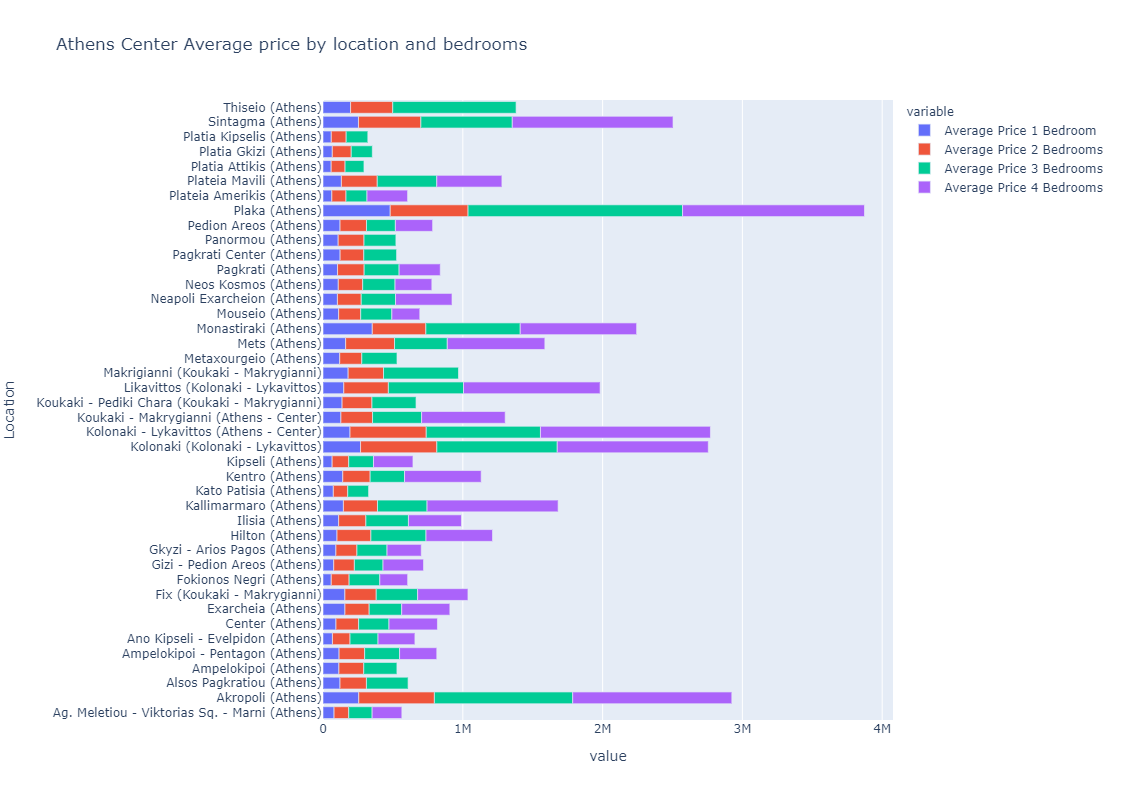

In [5]:
fig_sales_ath_center  = px.bar(fig_center_sales, y="Location", x=["Average Price 1 Bedroom","Average Price 2 Bedrooms", 
                          "Average Price 3 Bedrooms","Average Price 4 Bedrooms"],  #color="Average Price 1 Bedroom", 
             title="Athens Center Average price by location and bedrooms", width=1000, height=800, orientation='h')
fig_sales_ath_center.show()

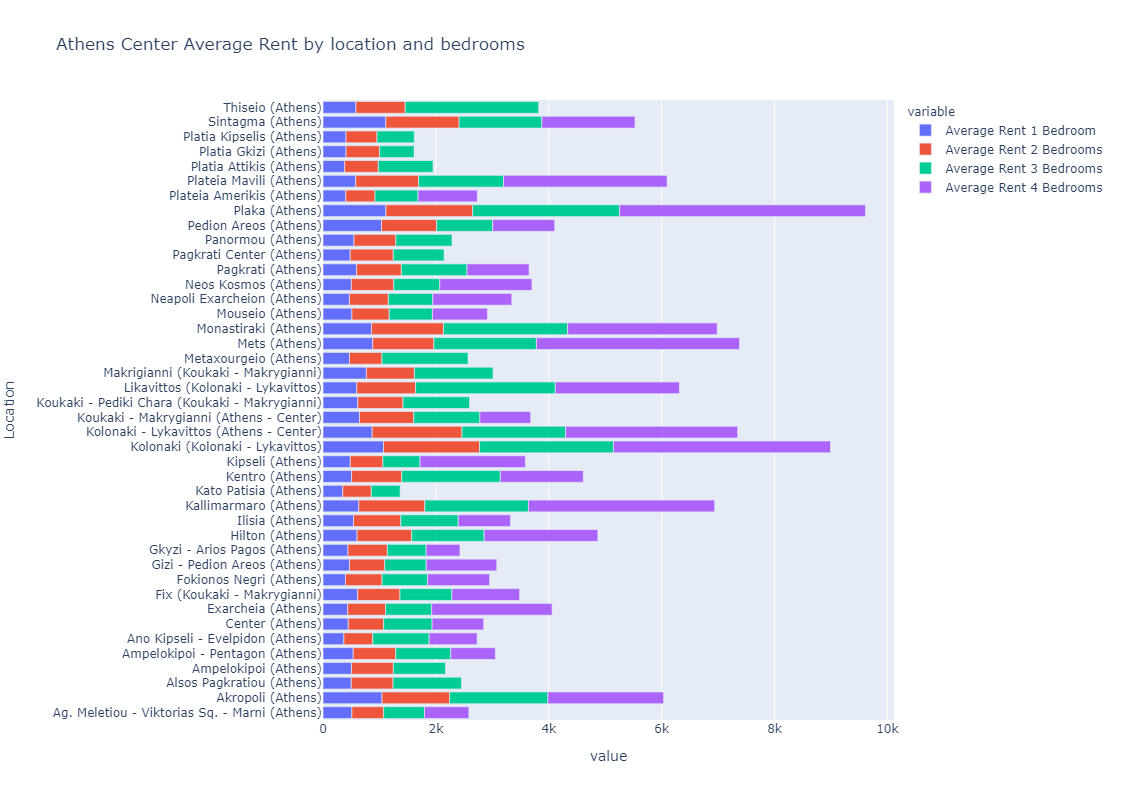

In [6]:
fig_rent_ath_center = px.bar(fig_center_rent, y="Location", x=["Average Rent 1 Bedroom","Average Rent 2 Bedrooms", 
                                    "Average Rent 3 Bedrooms","Average Rent 4 Bedrooms"],  #color="Average Price 1 Bedroom", 
             title="Athens Center Average Rent by location and bedrooms", width=1000, height=800, orientation='h')
fig_rent_ath_center.show()

<AxesSubplot:ylabel='Location'>

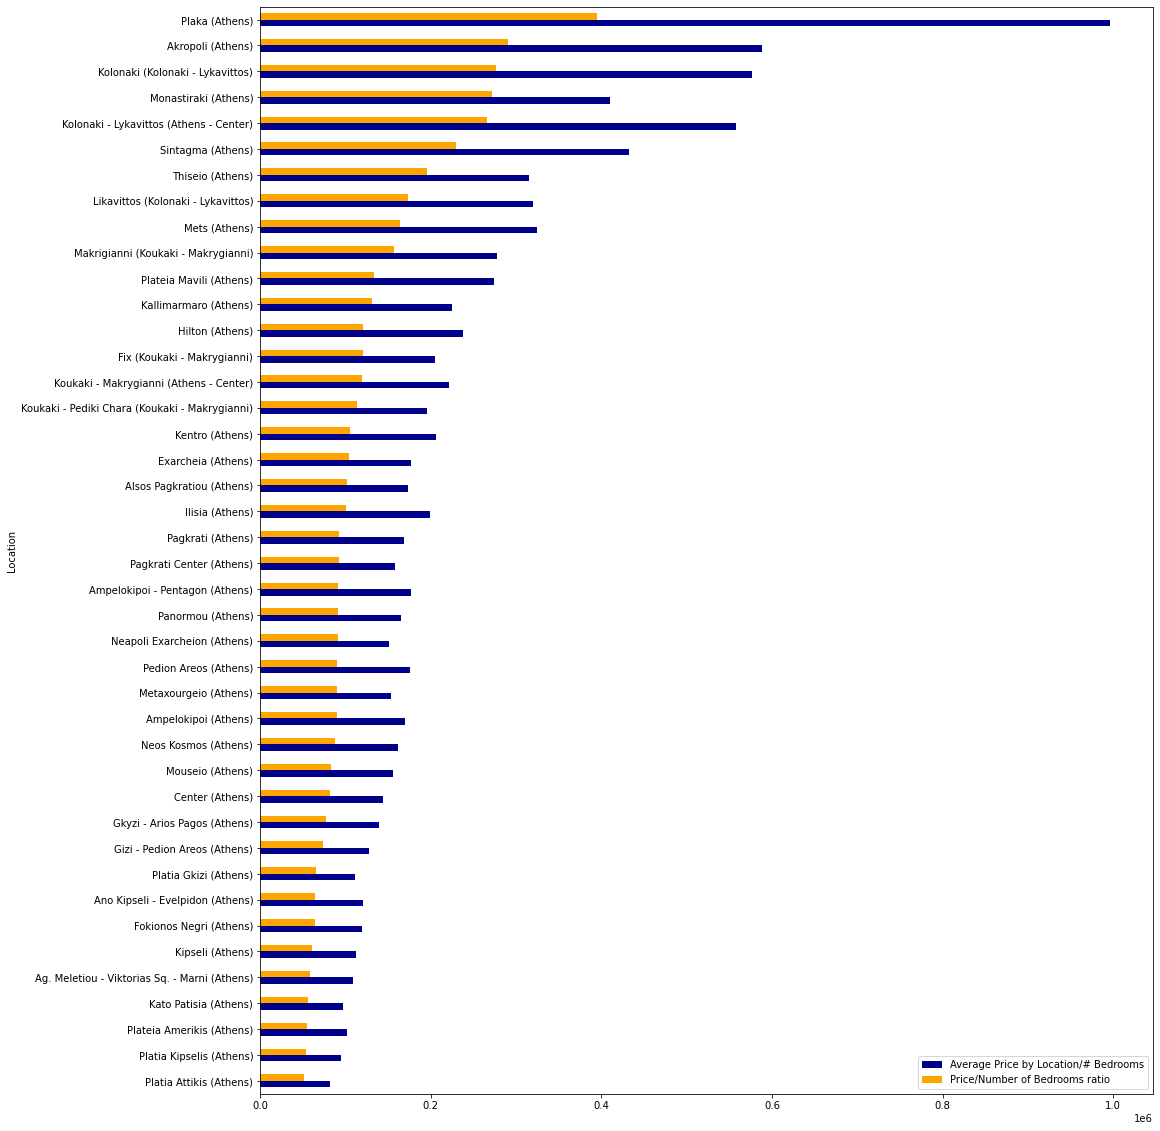

In [7]:
group_0 = df_merged_final.groupby('Location').mean()[['Average Price by Location/# Bedrooms' , 
    'Number of Bedrooms']].sort_values(by = 'Number of Bedrooms') 
group_0['Price/Number of Bedrooms ratio'] = group_0['Average Price by Location/# Bedrooms'] / group_0['Number of Bedrooms']
group_1 = group_0.drop(columns = ['Number of Bedrooms']).sort_values(by='Price/Number of Bedrooms ratio')
group_1.plot.barh(figsize = (16,20) , color = ['darkblue', 'orange'] )

<AxesSubplot:ylabel='Location'>

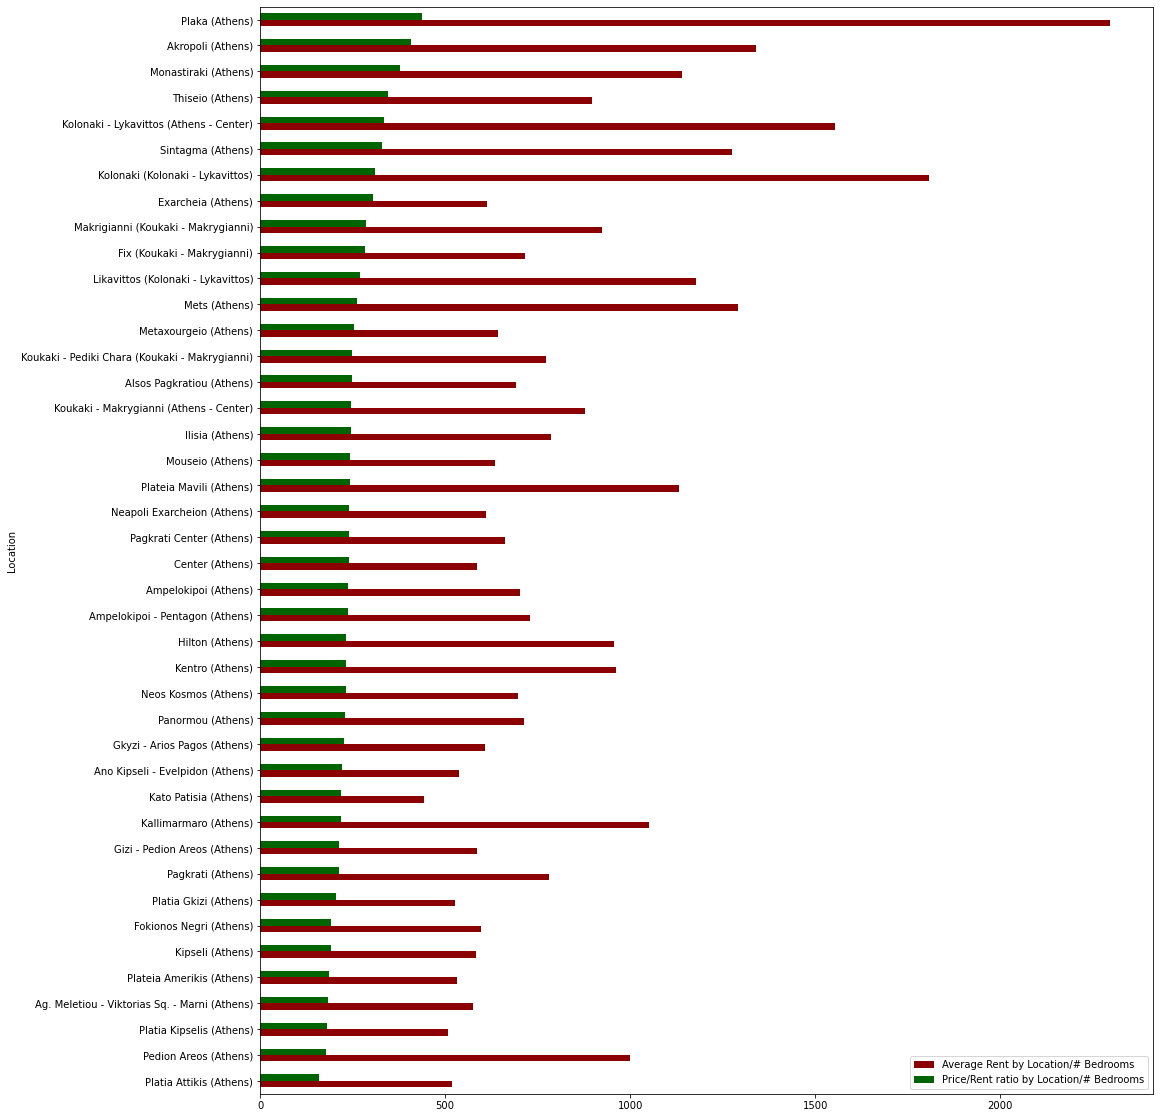

In [8]:
group_2 = df_merged_final.groupby('Location').mean()[['Average Rent by Location/# Bedrooms' , 
    'Price/Rent ratio by Location/# Bedrooms']].sort_values(by = 'Price/Rent ratio by Location/# Bedrooms')
group_2.plot.barh(figsize = (16,20) , color = ['darkred', 'darkgreen'] )

In [9]:
df_merged_final

,Price,Square meters house,Number of Bedrooms,Location,Average Price by Location/# Bedrooms,Average Square meters by Location/# Bedrooms,Average Rent by Location/# Bedrooms,Price per m^2,Average Price per m^2 by Location/# Bedrooms,Average Rent per m^2 by Location/# Bedrooms,Price/Rent ratio by Location/# Bedrooms,Property_Valuation,Property_Valuation_Dummy,Location_Dummy
0,260000.0,98.0,3.0,Alsos Pagkratiou (Athens),297950.00,115.20,1212.50,2653.06,2586.37,10.53,245.73,Fair_Vlue,1,2
1,153000.0,64.0,2.0,Alsos Pagkratiou (Athens),188960.67,84.08,740.57,2390.62,2247.39,8.81,255.16,Fair_Vlue,1,2
2,62000.0,47.0,1.0,Alsos Pagkratiou (Athens),121759.74,52.61,500.69,1319.15,2314.38,9.52,243.18,Fair_Vlue,1,2
3,180000.0,77.0,2.0,Alsos Pagkratiou (Athens),188960.67,84.08,740.57,2337.66,2247.39,8.81,255.16,Fair_Vlue,1,2
4,161000.0,70.0,2.0,Alsos Pagkratiou (Athens),188960.67,84.08,740.57,2300.00,2247.39,8.81,255.16,Fair_Vlue,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17154,120000.0,75.0,2.0,Ilisia (Athens),194970.00,88.77,836.97,1600.00,2196.35,9.43,232.95,Fair_Vlue,1,13
17155,275000.0,130.0,3.0,Ilisia (Athens),304387.76,110.98,1018.00,2115.38,2742.73,9.17,299.01,Fair_Vlue,1,13
17156,180000.0,78.0,2.0,Ilisia (Athens),194970.00,88.77,836.97,2307.69,2196.35,9.43,232.95,Fair_Vlue,1,13
17157,90000.0,47.0,1.0,Ilisia (Athens),111777.78,54.56,541.43,1914.89,2048.71,9.92,206.45,Fair_Vlue,1,13


## Predicting House Valuations and House Prices

Using Tensorflow, we will establish three neural network models: The first will classify a house based on its approximated valuations, the second will predict house prices based on specific attributes and the final will again find the valuation of the house based on the predicted price of the second model.

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
import seaborn as sns

### Classification Model

The first model is to identify the valuation of the house. We have already established a metric that classifies a house as Undervalued/Fairly Valued/Overvalued (Price/Rent ratio by Location/# Bedrooms). The model will be trained to predict the house valuation based on house characterisics (Price, Square meters house, Number of Bedrooms, Average Price by Location/# Bedrooms, Property_Valuation_Dummy, Average Rent by Location/# Bedrooms) 

In [11]:
df_model = df_merged_final[["Price", "Square meters house", "Number of Bedrooms",'Average Price by Location/# Bedrooms',
                            'Property_Valuation_Dummy', 'Average Rent by Location/# Bedrooms']].copy()

#df_model = df_merged_final[["Price", "Square meters house", "Number of Bedrooms",'Property_Valuation_Dummy']].copy()


features = df_model[["Price", "Square meters house", "Number of Bedrooms",'Average Price by Location/# Bedrooms'
                     ,'Average Rent by Location/# Bedrooms']] 

#features = df_model[["Price", "Square meters house", "Number of Bedrooms"]] 


labels = df_model['Property_Valuation_Dummy']


features_train, features_test, labels_train, labels_test = train_test_split(features, labels, random_state=None, test_size=.2)

In [12]:
model = tf.keras.Sequential([
    preprocessing.Normalization() ,
    tf.keras.layers.Flatten(input_shape=(1,1)),
    tf.keras.layers.Dense(243, activation='relu'),
    tf.keras.layers.Dense(3)
])

model.compile(optimizer='adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',]
             )

real_estate_classification_model = model.fit(features_train, labels_train, epochs=100, verbose = 0, )

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
flatten (Flatten)            (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 243)               1458      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 732       
Total params: 2,201
Trainable params: 2,190
Non-trainable params: 11
_________________________________________________________________
None


In [14]:
history_classification = pd.DataFrame(real_estate_classification_model.history)
history_classification['epoch'] = real_estate_classification_model.epoch
history_classification.tail(10)

,loss,accuracy,epoch
90,11.431108,0.952648,90
91,22.037991,0.928244,91
92,16.384447,0.938078,92
93,21.879414,0.935019,93
94,10.713879,0.943906,94
95,16.057751,0.927661,95
96,15.126372,0.933634,96
97,10.036615,0.943178,97
98,14.053955,0.932906,98
99,14.941085,0.929191,99


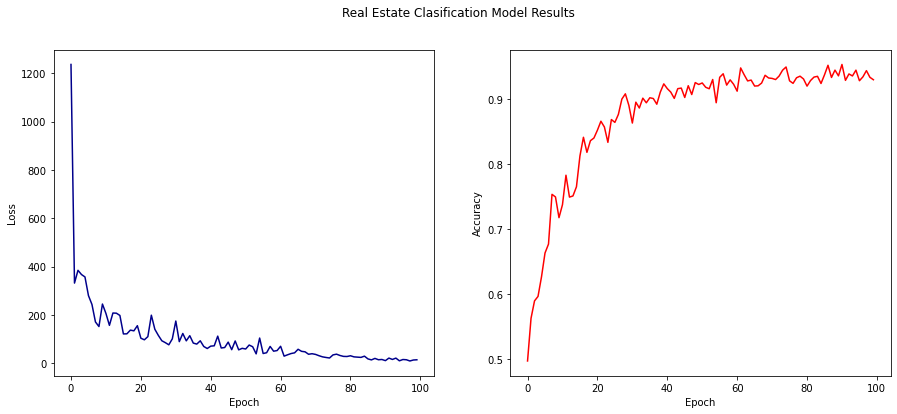

In [15]:
fig,ax = plt.subplots(1,2, figsize=(15,6))

plt.suptitle('Real Estate Clasification Model Results')
plt.rcParams['font.size'] = '16'


ax[0].plot(history_classification['loss'], color = 'darkblue')
ax[0].set(xlabel = 'Epoch' , ylabel='Loss')

ax[1].plot(history_classification['accuracy'], color = 'red')
ax[1].set(xlabel = 'Epoch', ylabel='Accuracy')

plt.grid(False)

In [16]:
test_loss, test_acc = model.evaluate(features_test,  labels_test, verbose=2)

108/108 - 0s - loss: 26.7031 - accuracy: 0.8348


In [17]:
predictions_classification = model.predict(features_test)

In [18]:
def house_prediction(i):
    if np.argmax(predictions_classification[i]) == 0:
        print('Undervalued')
    elif np.argmax(predictions_classification[i]) == 1:
        print('Fairly Valued')
    elif np.argmax(predictions_classification[i]) == 2:
        print('Overvalued')

In [19]:
house_prediction(4)

Fairly Valued


In [20]:
df_merged_final.iloc[4]

Price                                                              161000
Square meters house                                                    70
Number of Bedrooms                                                      2
Location                                        Alsos Pagkratiou (Athens)
Average Price by Location/# Bedrooms                               188961
Average Square meters by Location/# Bedrooms                        84.08
Average Rent by Location/# Bedrooms                                740.57
Price per m^2                                                        2300
Average Price per m^2 by Location/# Bedrooms                      2247.39
Average Rent per m^2 by Location/# Bedrooms                          8.81
Price/Rent ratio by Location/# Bedrooms                            255.16
Property_Valuation                                              Fair_Vlue
Property_Valuation_Dummy                                                1
Location_Dummy                        

As we can see the valuation of a house that the model predicted (house_predictions) and the actual house valuation, almost always are the same, as the accuracy of the model is close to 96%. 

### Regression Model

In [21]:
df_regression = df_merged_final.drop(columns = ['Location', 'Property_Valuation']).copy()


train_dataset = df_regression.sample(frac=0.8, random_state=0)
test_dataset = df_regression.drop(train_dataset.index)

regression_train_features = train_dataset.drop(columns = 'Price')
regression_train_labels = train_dataset['Price']

regression_test_features = test_dataset.drop(columns = 'Price')
regression_test_labels = test_dataset['Price']

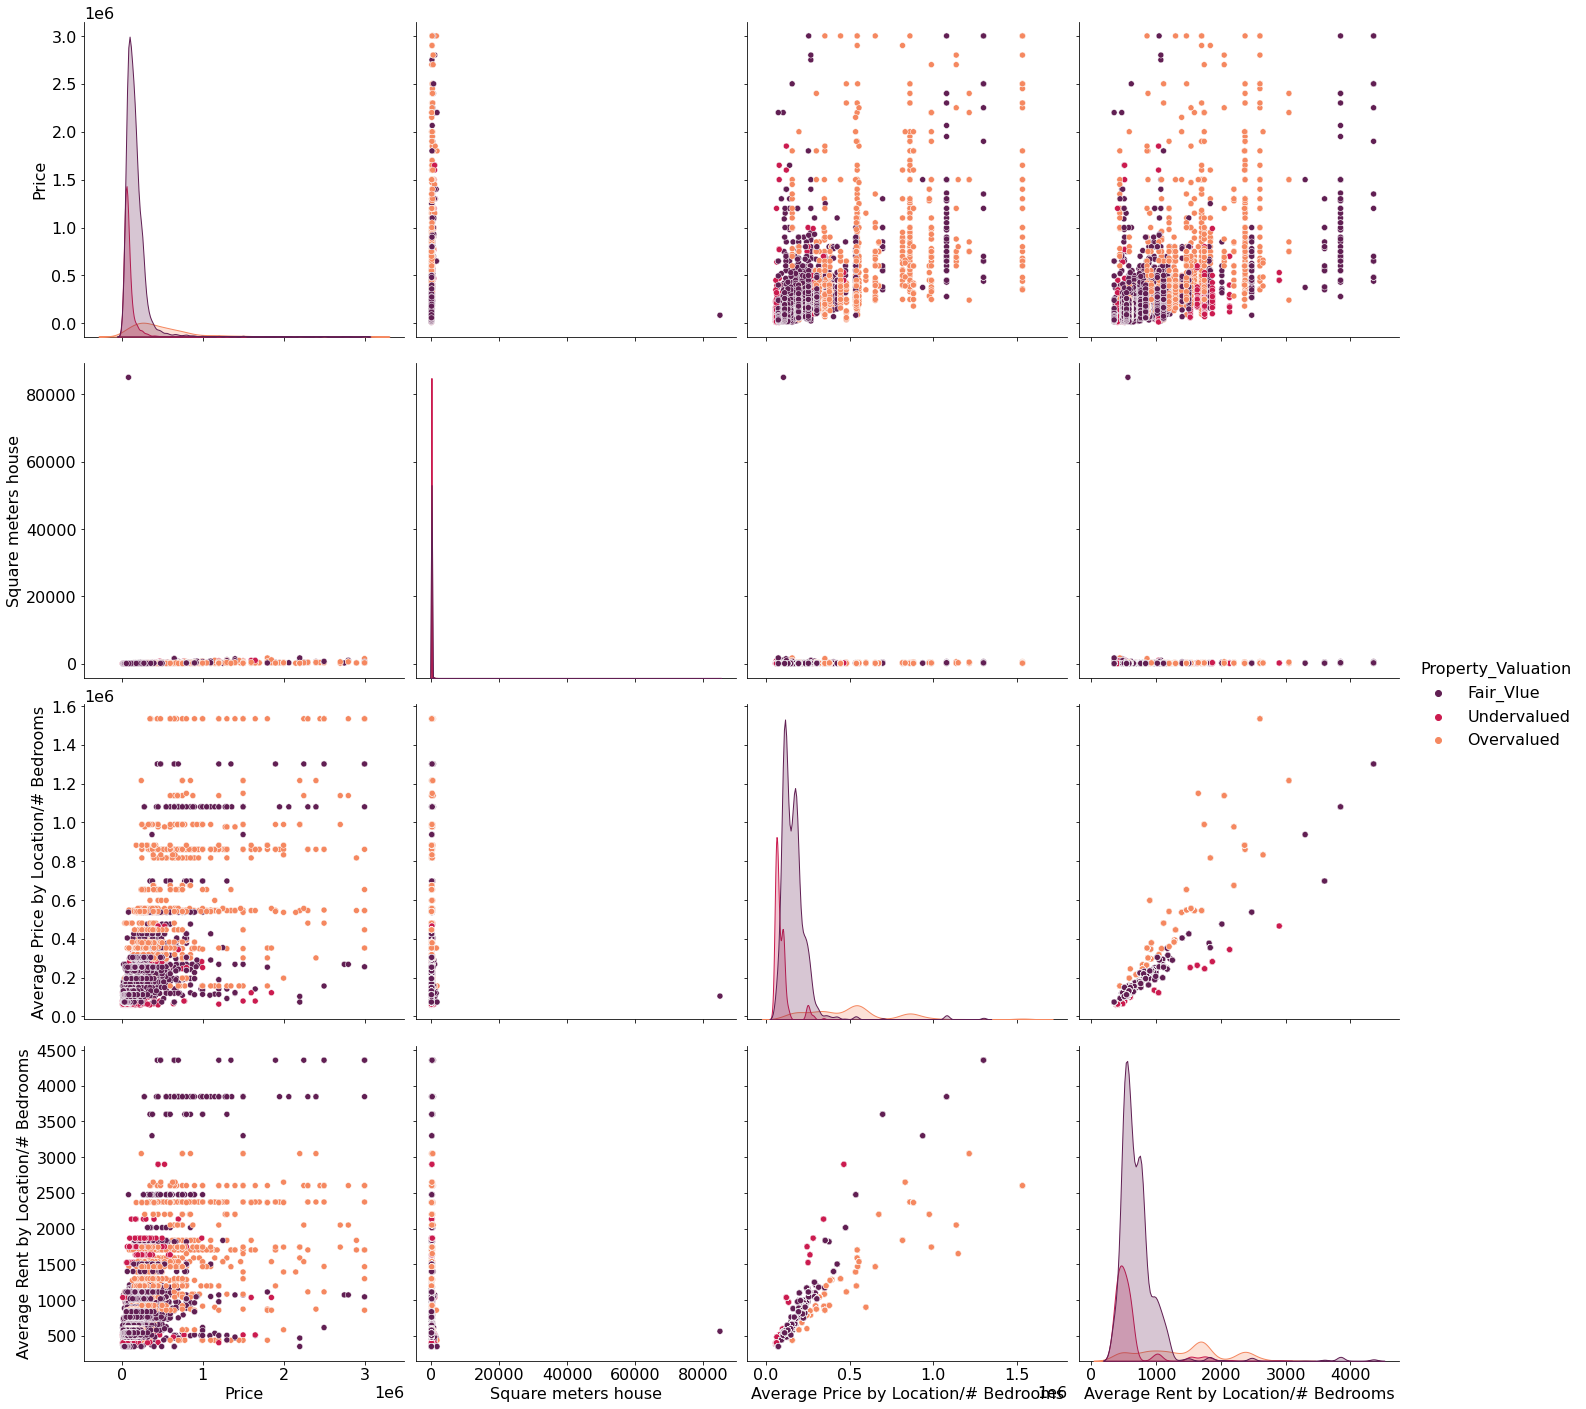

In [22]:
sns.pairplot(df_merged_final[['Price', 'Square meters house','Average Price by Location/# Bedrooms'
                        , 'Average Rent by Location/# Bedrooms', 'Property_Valuation' ]] , diag_kind='kde', height=5,hue='Property_Valuation', palette = 'rocket')

In [23]:
normalizer = preprocessing.Normalization()

normalizer.adapt(np.array(regression_train_features))

print(normalizer)


In [24]:
regression_model = tf.keras.Sequential([normalizer,
                                      tf.keras.layers.Dense(200, activation='relu'),
                                      tf.keras.layers.Dense(42, activation='relu'),
                                      #tf.keras.layers.Dense(3, activation='relu'),
                                      tf.keras.layers.Dense(1),
                                      ])

regression_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',
      )
    


real_estate_regression_model = regression_model.fit(regression_train_features, regression_train_labels, epochs=100, verbose = 0 , validation_split = 0.2)

#regression_features_train, regression_features_test, regression_labels_train, regression_labels_test

In [25]:
print(regression_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 11)                23        
_________________________________________________________________
dense_2 (Dense)              (None, 200)               2400      
_________________________________________________________________
dense_3 (Dense)              (None, 42)                8442      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 43        
Total params: 10,908
Trainable params: 10,885
Non-trainable params: 23
_________________________________________________________________
None


In [26]:
history_regression = pd.DataFrame(real_estate_regression_model.history)
history_regression['epoch'] = real_estate_regression_model.epoch
history_regression

,loss,val_loss,epoch
0,65955.164062,45226.417969,0
1,50609.285156,40971.867188,1
2,51491.312500,40436.644531,2
3,46901.085938,38018.539062,3
4,49251.820312,34976.281250,4
...,...,...,...
95,4332.838867,4125.176758,95
96,4575.972168,3072.398682,96
97,4196.121094,4662.783691,97
98,4727.255859,3998.495361,98


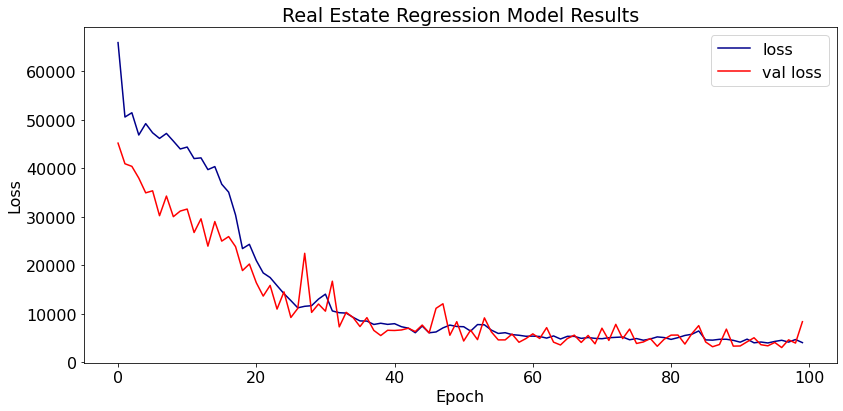

In [27]:
train_loss = history_regression['loss'].tolist()
test_loss = history_regression['val_loss'].tolist()

fig, ax = plt.subplots(figsize=(12,6))

plt.rcParams['font.size'] = '16'


ax.plot(train_loss, color='darkblue', label='loss')

ax.plot(test_loss, color='red', label='val loss')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Real Estate Regression Model Results')
ax.legend()

fig.tight_layout()

Now let's predict the price of a given house

In [28]:
regression_predictions = regression_model.predict(regression_test_features).flatten()


In [29]:
regression_predictions

array([ 62890.094, 153829.97 ,  62890.094, ..., 215737.06 , 344900.56 ,
       112739.1  ], dtype=float32)

In [30]:
regression_test_labels.to_numpy()

array([ 62000., 155000.,  62000., ..., 220000., 360000., 115000.])

In [31]:
df_regression_predictions = regression_test_features.reset_index().drop(columns = 'index')
df_regression_predictions['Predicted_price'] = regression_predictions

In [32]:
df_regression_predictions

,Square meters house,Number of Bedrooms,Average Price by Location/# Bedrooms,Average Square meters by Location/# Bedrooms,Average Rent by Location/# Bedrooms,Price per m^2,Average Price per m^2 by Location/# Bedrooms,Average Rent per m^2 by Location/# Bedrooms,Price/Rent ratio by Location/# Bedrooms,Property_Valuation_Dummy,Location_Dummy,Predicted_price
0,47.0,1.0,121759.74,52.61,500.69,1319.15,2314.38,9.52,243.18,1,2,62890.093750
1,64.0,2.0,188960.67,84.08,740.57,2421.88,2247.39,8.81,255.16,1,2,153829.968750
2,47.0,1.0,121759.74,52.61,500.69,1319.15,2314.38,9.52,243.18,1,2,62890.093750
3,100.0,2.0,188960.67,84.08,740.57,1850.00,2247.39,8.81,255.16,1,2,182271.656250
4,88.0,2.0,188960.67,84.08,740.57,2500.00,2247.39,8.81,255.16,1,2,216796.812500
...,...,...,...,...,...,...,...,...,...,...,...,...
3427,110.0,2.0,194970.00,88.77,836.97,1818.18,2196.35,9.43,232.95,1,13,196072.250000
3428,62.0,2.0,194970.00,88.77,836.97,1500.00,2196.35,9.43,232.95,1,13,91062.062500
3429,103.0,2.0,194970.00,88.77,836.97,2135.92,2196.35,9.43,232.95,1,13,215737.062500
3430,122.0,3.0,304387.76,110.98,1018.00,2950.82,2742.73,9.17,299.01,1,13,344900.562500


### Classification Model based on Regression Predictions

In [33]:
df_classification_cond_regression = df_regression_predictions[["Predicted_price", "Square meters house", "Number of Bedrooms",'Average Price by Location/# Bedrooms',
                            'Property_Valuation_Dummy', 'Average Rent by Location/# Bedrooms']].copy()


classif_cond_reg_features = df_classification_cond_regression.drop(columns = ['Property_Valuation_Dummy'])


classif_cond_reg_labels = df_classification_cond_regression['Property_Valuation_Dummy']



classif_cond_reg_features_train, classif_cond_reg_features_test,classif_cond_reg_labels_train, classif_cond_reg_labels_test = train_test_split(classif_cond_reg_features, 
                                                                                classif_cond_reg_labels, random_state=None, test_size=.2)

In [34]:
class_reg_model = tf.keras.Sequential([
    preprocessing.Normalization() ,
    tf.keras.layers.Flatten(input_shape=(1,1)),
    tf.keras.layers.Dense(243, activation='relu'),
    tf.keras.layers.Dense(3)
])

class_reg_model.compile(optimizer='adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',]
             )

real_estate_reg_classif_model = class_reg_model.fit(classif_cond_reg_features_train, classif_cond_reg_labels_train, epochs=100, verbose = 0,)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
flatten (Flatten)            (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 243)               1458      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 732       
Total params: 2,201
Trainable params: 2,190
Non-trainable params: 11
_________________________________________________________________
None


In [35]:
history_reg_class_model = pd.DataFrame(real_estate_reg_classif_model.history)
history_reg_class_model['epoch'] = real_estate_reg_classif_model.epoch
history_reg_class_model.tail(10)

,loss,accuracy,epoch
90,181.882019,0.812022,90
91,151.580505,0.834973,91
92,299.441315,0.748270,92
93,117.046997,0.839344,93
94,285.440552,0.773406,94
95,204.270020,0.803643,95
96,189.217346,0.779599,96
97,95.954063,0.875046,97
98,103.692513,0.887796,98
99,111.103310,0.846630,99


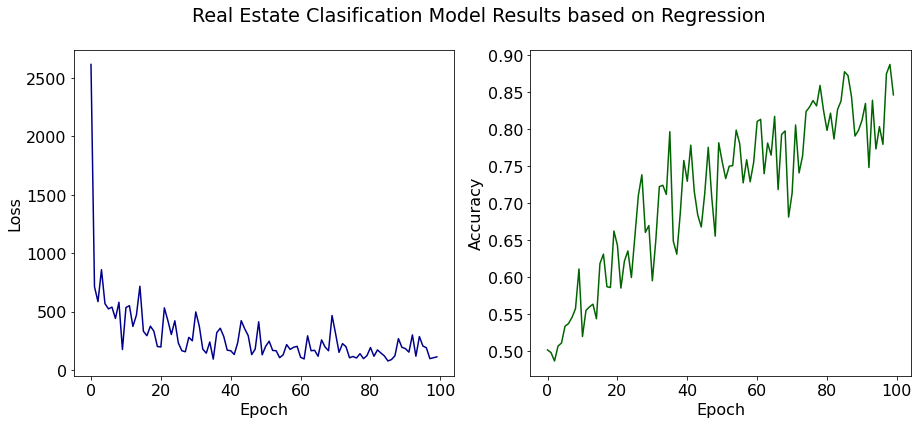

In [36]:
fig,ax = plt.subplots(1,2, figsize=(15,6))

plt.suptitle('Real Estate Clasification Model Results based on Regression')
plt.rcParams['font.size'] = '16'


ax[0].plot(history_reg_class_model['loss'], color = 'darkblue')
ax[0].set(xlabel = 'Epoch' , ylabel='Loss')

ax[1].plot(history_reg_class_model['accuracy'], color = 'darkgreen')
ax[1].set(xlabel = 'Epoch', ylabel='Accuracy')

plt.grid(False)

In [37]:
test_loss, test_acc = class_reg_model.evaluate(features_test,  labels_test, verbose=2)

108/108 - 0s - loss: 40.3909 - accuracy: 0.9572


In [38]:
predictions_reg_class = model.predict(classif_cond_reg_features_test)

In [39]:
def house_prediction_final(i):
    if np.argmax(predictions_reg_class[i]) == 0:
        print('Undervalued')
    elif np.argmax(predictions_reg_class[i]) == 1:
        print('Fairly Valued')
    elif np.argmax(predictions_reg_class[i]) == 2:
        print('Overvalued')

In [40]:
house_prediction_final(4)

Fairly Valued


In [41]:
df_classification_cond_regression.iloc[4]

Predicted_price                         216796.8125
Square meters house                         88.0000
Number of Bedrooms                           2.0000
Average Price by Location/# Bedrooms    188960.6700
Property_Valuation_Dummy                     1.0000
Average Rent by Location/# Bedrooms        740.5700
Name: 4, dtype: float64